# Vader Sentiment Analysis of First 100 Days of the Trump Administration

For more information about how Vader works behind the scenes see here: https://github.com/cjhutto/vaderSentiment

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.   

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes). 

- **nltk:** Platform for building Python programs to work with human language data. Here we bring in the VADER sentiment analysis tool which is now a part of the nltk package.

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

- **numpy:** The fundamental package for scientific computing with Python.

- **os:** This module provides a portable way of using operating system dependent functionality.

- **csv:** Implements classes to read and write tabular data in CSV format.

- **json:** Used to parse and manipulate data in JSON format.

- **calendar:** Allows you to output calendars like the Unix cal program, and provides additional useful functions related to the calendar.

- **time:** Provides various time-related functions.

- **datetime:** Supplies classes for manipulating dates and times in both simple and complex ways.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import os
import csv
import json
import calendar
import time
from datetime import date, timedelta
import re
import string
import glob

/N/soft/rhel7/anaconda/python3.6/4.3.1/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Here we save the two file paths we will need throughout this notebook. This way we only need to make changes here and they will be implemeneted throughout the code. Change these to match where your data can be found (dataHome) and where you want any output such as .csv files or images to be saved (dataResults).

In [2]:
dataHome = '/N/u/klosteda/Carbonate/Text-Analysis-master/data/twitter'
dataResults = '/N/u/klosteda/Carbonate/Text-Analysis-master/Output'

#### Shorten SentimentIntensityAnalyzer Function
We shorten the SentimentIntensityAnalyzer() to just 'vader' (minus the quotes).

In [3]:
vader = SentimentIntensityAnalyzer()

### Functions
We need to create a few functions in order to calculate the sentiment score and graph the scores over time. Any time you see 'def' (without the quotes) that means we are DEclaring a Function. The 'def' is usually followed by the name of the function being created and then in parentheses are the arguments the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed or in other words what the function is doing. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required arguments in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

Here we have functions to get the month number from the three letter abreviation used in the tweet data. Another function to write out the year/month/day of the tweet, then we get the month, day, and year from the JSON file(s), then we create a function to score the tweets with VADER, then we create a function to store data in a list, and finally we have a function to return only ascii encoded text. You should not need to make any changes to this part of the code.

In [4]:
def getMonthNumber(month):
    if month == "Jan":
        return 1
    elif month == "Feb":
        return 2
    elif month == "Mar":
        return 3
    elif month == "Apr":
        return 4
    elif month == "May":
        return 5
    elif month == "Jun":
        return 6
    elif month == "Jul":
        return 7
    elif month == "Aug":
        return 8
    elif month == "Sep":
        return 9
    elif month == "Oct":
        return 10
    elif month == "Nov":
        return 11
    else:
        return 12

def nextWeekString(year, month, day):
    nextDate = date(year, month, day) + timedelta(1)
    return nextDate
    
def getMonthFromJson(created_at):
    return getMonthNumber(created_at[4:7])

def getDayFromJson(created_at):
    return int(created_at[8:10])

def getYearFromJson(created_at):
    return int(created_at[26:])

#scores tweet using vader and returns the compound
def scoreVader(text):
    vs = vader.polarity_scores(text)
    return vs['compound']



def lines2list(filepath, encoding = 'utf-8', commentChar = None):
    
    with open(filepath, 'r', encoding = encoding) as f:
        lines = f.readlines()
        
        if commentChar is not None:
            lines = [x for x in lines if not x.startswith(commentChar)]
        
        # strip each line
        lines = [x.strip() for x in lines]
        
        # eliminate empty lines  
        lines = [x for x in lines if x]  
        
    return lines

def isAscii(s):
    return all(ord(c) < 128 for c in s)



#### Read the 'text' and 'created_at' key in the JSON file

Here we read in our twitter data which is in JSON format. The only lines you will need to change are the folder and file name after it says 'for file in glob.glob...' so that it matches where you have your data stored.

In [5]:
#variable for mean of scores for a given week on VADER
vaderScores = []

#variable for storing all vader scores
allVaderScores = []

#variable storing date associated with the scores
weeklyDates = []

#stores the sum of all vader tweet scores for calculation of mean
vaderSum = 0

#stores the number of tweets per week for calculation of mean
weekNum = 0

#stores the date when the current week will end and the next will begin
stopDate = date(2019,1,23)

#stores the current date of any individual tweet as the program runs 
currentDate = date(2016, 8, 1)

for file in glob.glob(os.path.join(dataHome, "JSON/*")):
    with open(file, mode = 'r', encoding = "utf8") as read:
        #if a file starts a new week, currentDate and stopDate must be initialized
        if weekNum == 0:
            first = json.loads(next(read))
            created_at = first['created_at']
            month = getMonthFromJson(created_at)
            day = getDayFromJson(created_at)
            year = getYearFromJson(created_at)
            currentDate = date(year, month, day)
            stopDate = nextWeekString(year, month, day)
               
        for line in read:
            data = json.loads(line)
            created_at = data['created_at']
            currentMonth = getMonthFromJson(created_at)
            currentDay = getDayFromJson(created_at)
            currentYear = getYearFromJson(created_at)
            currentDate = date(currentYear, currentMonth, currentDay)
            if currentDate >= stopDate:
                vaderMean = vaderSum / weekNum
                vaderScores.append(vaderMean)
                weeklyDates.append(currentDate)
                vaderSum = 0
                weekNum = 0
                month = stopDate.month
                day = stopDate.day
                year = stopDate.year
                currentDate = date(year, month, day)
                stopDate = nextWeekString(year, month, day)
            vaderScore = scoreVader(data['text'])
            vaderSum += vaderScore
            
            allVaderScores.append(vaderScore)
            weekNum += 1
                
        
        print("Finished reading " + str(file))
        
#if there is unsaved data
if(weekNum != 0): 
    vaderMean = vaderSum / weekNum
    vaderScores.append(vaderMean)
    weeklyDates.append(currentDate)

Finished reading /N/u/klosteda/Carbonate/Text-Analysis-master/data/twitter/JSON/part-m-00000


#### Save results as .csv file

Here we save the dates and the scores for those dates in a .csv file so you have them if you need to see the exact scores later. The only thing you might need to change is what you want to name the file. We are naming it 'vaderWeeklyScoresTest.csv' (with the quotes) for now. Feel free to change it to what you want.

In [6]:
with open(os.path.join(dataResults, 'vaderWeeklyScoresTest.csv'), "w") as write:
    writer = csv.writer(write)
    writer.writerows([vaderScores])
    writer.writerows([weeklyDates])

This computes a zscore. This is only needed if you are comparing two different sets of scores as this normalizes the scores so that if they have a different means of scoring you can still accurately compare them.

In [7]:
from scipy import stats
vaderZScores = stats.zscore(vaderScores)

### Plot the graph

Here we plot the graph. The places you will want to make changes are ax.xaxis.set_major_formatter, plt.title, plt.xlim, and plt.savefig. 

For ax.xaxis.set_major_formatter you may want to change '%m/%d/%Y' as this says we want the dates to have the month, day, and year. You may want just month and year which would look like '%m/%Y'. 

For plt.title change the title to fit your own data.

For plt.xlim change the dates to coincide with what matches your data.

For plt.savefig change the file name to match your own data.

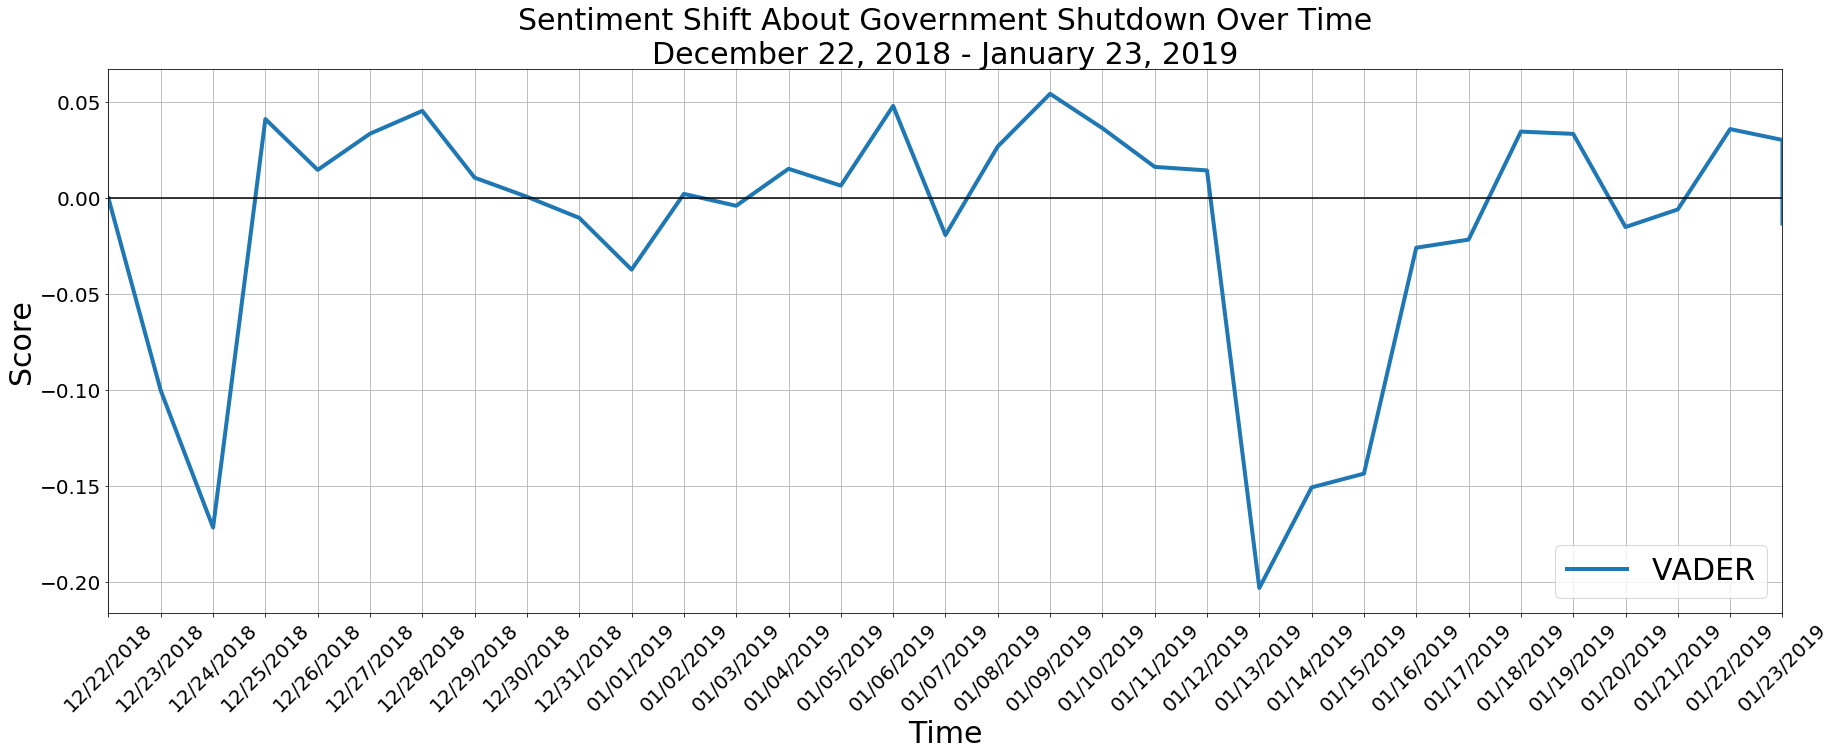

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

fig = plt.figure(figsize=(30,10))
ax = plt.subplot()
ax.plot(weeklyDates, vaderScores, label = 'VADER', linewidth = 4)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.grid()
ax.axhline(color = 'black')
ax.legend(loc = 4, prop = {'size':30})
#ax.axvline(date(2017, 1,26))

#plt.plot(weeklyDates, vaderZScores)
plt.xlabel('Time', fontsize = 30)
plt.ylabel('Score', fontsize = 30)
plt.title('Sentiment Shift About Government Shutdown Over Time\nDecember 22, 2018 - January 23, 2019', fontsize = 30)
plt.xticks(size = 20, rotation = 45)
plt.yticks(size = 20)
plt.xlim((date(2018, 12,22), date(2019, 1, 23)))

plt.show()
fig.savefig(os.path.join(dataResults, 'vaderSentimentShiftGraph.png'), format='png', dpi=300, bbox_inches='tight')


## VOILA!!

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.